# Implémentation du cryptosytème de Kifli

Dans ce notebook vous pourrez retrouver nos travaux sur l'implémentation du cryptosytème de Kifli.

En premier lieu vous pourrez retrouver l'implémentation concrète en langage Python du cryptosytème, avec nottamment l'implémentation des méthodes indiqués dans le sujet : 
- `gen_pochon(n)` qui génère un pochon de taille $n$.
- `gen_cle_privee(n)` qui génère une clé privée.
- `gen_cle_publique(cle_privee)` qui génère la clé publique à partir de 
la clé privée.
- `solve_pochon(pochon, c)` qui résout un problème de *pochon*.
- `chiffre(message, cle_publique)` qui chiffre un message.
- `dechiffre(message_chiffre, cle_privee)` qui déchiffre un message.
- `test_chiffrement_dechiffrement(message, n)` qui créé une paire de clés et chiffre et déchiffre un message puis vérifie que le message déchiffré est bien égal au message initial.

En second lieu, notre analyse de critique de cette implémentation via une analyse de l'éxécution et de sa valididé comme algorithme. post-quantique

Equipe : 
- Matis Olives
- Quentin Artigala
- Illan Gabarra

## Algorithmes d'Euclide utilisés

Afin de calculer `w` ainsi que son inverse modulaire, nous avons implémenté l'algorithme d'Euclide, ansi que sa version étendue. Nous pouvons donc déterminer quelles valeurs de `w` sont premières avec `M`, et le coefficient de Bezout. Nous avons conservé la version impérative car, pour $n$ assez grand, il sera impossible de réaliser l'algorithme en version récursive.

In [2]:
def algo_Euclide(a, b):
    """Algorithme d'Euclide non récursif pour le calcul du PGCD de a et b"""
    while b != 0:
        a, b = b, a % b
    return a

def algo_Euclide_etendu(a, b):
    """Algorithme d'Euclide étendu pour le calcul du PGCD de a et b et de u et v tels que au+bv=PGCD(a,b)"""
    u1, u2, v1, v2 = 1, 0, 0, 1
    while b != 0:
        q, r = divmod(a, b)
        a, b = b, r
        u1, u2 = u2, u1 - q * u2
        v1, v2 = v2, v1 - q * v2
    return a, u1, v1


## Génération de la paire clé privée, clé publique

In [3]:
# Importation des bibliothèques utilisées pour la génération de nombres aléatoires
import random as rd
from sys import maxsize
        
def gen_pochon(n):
    """Génération d'un pochon de n entiers supercroissants aléatoires """
    tab = []
    somme = 0
    for i in range(n):
        b = rd.randint(somme+1, somme+maxsize//n)
        somme += b
        tab.append(b)
    return tab

def gen_W(M):
    """Génération d'un entier aléatoire w premier avec M"""
    w=rd.randint(1, M-1)
    while(algo_Euclide(w,M)!=1):
        w=rd.randint(1, M-1)
    return w

def gen_permutation(n):
    """Génération d'une permutation aléatoire de [1,n]"""
    sigma = list(range(1, n+1))
    rd.shuffle(sigma)
    return sigma

def gen_cle_privee(n):
    """
    Génère une clé privée du cryptosystème de Kifli. Une clé privée contient un pochon P,
    un entier M tel que la somme du pochon < M, W entier aléatoire entre 1 et M et premier avec ce dernier,
    et sigma, représentant une permutation aléatoire des indices du pochon.

    Paramètres:
        n : La taille du pochon et de sigma.

    Retourne:
        (p, m, w, sigma) : La clé privée sous forme de quadruplet.
    """

    # Génération d'un pochon
    p = gen_pochon(n)

    # Génération d'un nombre m entre la somme des éléments du pochon et sys.maxsize//n
    m = rd.randint(sum(p) + 1, sum(p) + maxsize//n)

    # Génération d'un nombre w premier avec m
    w = gen_W(m)

    # Génération d'une permutation aléatoire de [1,n]
    sigma = gen_permutation(n)
    
    return (p, m, w, sigma)

def gen_cle_publique(cle_privee):
    """Génération de la clé publique à partir de la clé privée """
    pochon, m, w, sigma = cle_privee
    cle_public=[0]*len(sigma)
    for i in range(len(sigma)):
        cle_public[i]=pochon[sigma[i]-1]*w%m
    return cle_public

## Chiffrement déchiffrement d'un message 

Souhaitant pouvoir chiffrer un message qui ne fasse pas forcément la taille de la clé ou taille du pochon (n) nous avons fait en sorte que le message transmis soit composé d'une liste d'entiers avec comme premier élément, la taille du dernier bloc chiffré. 
Sans cet élément on ne pourrait différencier un message `101` d'un message `10100` avec un pochon de taille 5 par exemple. 

Cas où le message fait la même taille que la clé:
- Le résultat est une liste de type : `[[tailleCle], [messageChiffre]]`
- Le message est donc déchiffré et aucune modification est effectuée sur le message déchiffré


Cas où le message fait une taille inférieur à la clé:
- Le résultat est une liste de type : `[[tailleMessage], [messageChiffre]]`
- Le message est déchiffré comme s'il était de taille n seulement `n - tailleMessage` bits à 0 sont rajoutés lors du déchiffrement de façon involontaire puis éliminés grace à l'information `tailleMessage` transmise.

Cas où le message fait une taille supérieur à la clé:
- Le résultat est une liste de type : `[[tailleDernierBloc], [blocMessageChiffre], [blocMessageChiffre], [blocMessageChiffre], ... ]`
- Chaque bloc est déchiffré séparemment puis les résultats sont concaténés les uns aux autres, selon la taille du dernier bloc une modification est réalisé au même titre que les scénarios cités précedemments mais où le message est la taille du dernier bloc.

### Chiffrement

In [4]:
def chiffre(message, cle_publique):
    '''
    Chiffre un message à partir d'une clé publique
    d'un crypto-système de Kifli

    Parametres :
        message      (str)   : Message encodé en binaire. ex : '10110'
        cle_publique (int[]) : Tableau d'entier correspondant à la clé publique

    Retourne :
        int[] : Une liste de bloc de message crypté ou le premier élément correspond à la taille du dernier bloc
    '''
    
    blocsMessageChiffre = []
    n = len(cle_publique) # n correspond à la taille maximum des blocs de message

    # On découpe tout d'abord le message en sous message d'une taille égale ou inférieure à la taille de la clé publique
    # Puis on parcours chacun de ces blocs
    for blocMessage in decoupMessage(message,n) :
        tailleDernierBloc = len(blocMessage)
        sommeC = 0

        # On parcours chaque bit du bloc de message
        for i in range (len(blocMessage)):
            if (blocMessage[i] == "1"):
                # On ajoute à la somme la valeur associé à la position du 1 dans le message qui est la valeur à l'index i du paquet A
                sommeC += cle_publique[i]
        blocsMessageChiffre.append((sommeC))

    # On rajoute en première position la taille du dernier bloc
    return [tailleDernierBloc] + blocsMessageChiffre

def decoupMessage(message,n):
    '''
    Découpe un message en plusieurs chaînes de caractères d'une taille n ou inférieure.
    Seulement le dernier bloc peut avoir une taille inférieure.

    Parametres :
        message (str) : Message à découper
        n       (int) : Taille 

    Retourne :
        str[] : Une liste de blocs du message
    '''

    messageDecoupe = []

    #Découpage jusqu'à que le message initial soit vide
    while len(message) > 0 :

        # Récupèration d'un bloc de taille n
        messageDecoupe.append(message[:n]) 

        # Changement du message afin d'enlever le bloc récupéré précedemment
        message = message[n:] 

    return messageDecoupe

### Déchiffrement

Composé de la méthode `solve_pochon(pochon, c)` permettant de résoudre le problème de pochon ainsi que la méthode `dechiffre(message_chiffre, cle_privee)` permettant de déchiffrer un message à partir de la clé privée

In [5]:
def solve_pochon(pochon, c):
    """
    Renvoie une solution au problème de pochon.

    Paramètres :
        pochon : Le pochon dont on veut résoudre son problème.
        c : Le nombre à comparer avec les éléments du pochon.

    Retour :
        E : La liste des indices du pochon qui résolvent le problème de pochon.
    """

    E = [0] * len(pochon)

    for i in reversed(range(len(pochon))):
        if pochon[i] <= c:
            E[i] = 1
            c -= pochon[i]

    return E

def dechiffre(message_chiffre, cle_privee):
    """
    Déchiffre un message chiffré par le cryptosystème de Kifli.

    Paramètres:
        message_chiffre : Le message chiffré par le cryptosystème de Kifli. Il est
        représenté par une liste, qui sert de découpage du message.
        cle_privee : La clé privée utilisée.

    Retourne :
        message_dechiffre : Le message déchiffré, sous forme d'une chaine de caractères.
    """

    # Inverse modulaire de W
    inverse_mod_w = algo_Euclide_etendu(cle_privee[2], cle_privee[1])[1] % cle_privee[1]
    # Nous avons considéré que la taille du dernier bloc de message était necessaire, elle est donc en première position dans le tableau d'entier du message chiffré
    taille_dernier_bloc = message_chiffre[0]
    message_dechiffre = ""
    # Récupéation du pochon
    P = cle_privee[0]
    # Récupération de la permutation des indices du pochon
    sigma=cle_privee[3]
    
    for message in message_chiffre[1:]:
        # Déterminer D tel que D = W^-1*message%M, avec W^-1 l'inverse modulaire de W.
        D = inverse_mod_w * message % cle_privee[1]

        # Résolution du problème de pochons        
        E = solve_pochon(P, D)

        sous_message = ["0"]*len(cle_privee[3])
        
        for i in range(len(sigma)):
            if(E[sigma[i]-1]==1):
                sous_message[i]="1"

        message_dechiffre += "".join(sous_message)

    # Découpage du dernier bloc, pour retirer les derniers éléments non-désirés, dans le cas où n est différent de la taille du message
    message_dechiffre = message_dechiffre[:len(message_dechiffre)-(len(P)-taille_dernier_bloc)]

    return message_dechiffre

        


# Tests de l'implémentation

## Test unitaires

Tests permettant de tester chaque méthode séparémment à partir de la paire de clés donnée en exemple.

Dans ces tests unitaires nous ne testons pas les méthodes générant la clé privée car cela est lié à l'aléatoire

In [6]:
cle_publique_test = [22,16,71,54,56]
n_test = 5
P_test = [2,5,11,23,55]
M_test = 113
W_test = 27
sigma_test = (2,5,3,1,4)
cle_priv_test=(P_test,M_test,W_test,sigma_test)

### Génération de clé publique

In [7]:
assert(gen_cle_publique(cle_priv_test) == cle_publique_test)

### Chiffrement

In [8]:
# Test pour le scénario où le message est de la même taille que le pochon
messageChiffre = chiffre('10101',cle_publique_test)
assert([5,149] == messageChiffre)

# Test pour le scénario où le message est d'une taille inférieur à celle du pochon
messageChiffre = chiffre('1101',cle_publique_test)
assert([4,92] == messageChiffre)

# Test pour le scénario où le message est d'une taille supérieure à celle du pochon
messageChiffre = chiffre('10100110',cle_publique_test)
assert([3,93,38]  == messageChiffre)

### Dechiffrement

In [9]:
# Test pour le scénario où le message est de la même taille que le pochon
messageDeChiffre = dechiffre([5,149],cle_priv_test)
assert("10101" == messageDeChiffre)

# Test pour le scénario où le message est d'une taille inférieur à celle du pochon
messageDeChiffre = dechiffre([4,92],cle_priv_test)
assert("1101" == messageDeChiffre)

# Test pour le scénario où le message est d'une taille supérieure à celle du pochon
messageDeChiffre = dechiffre([3,93,38],cle_priv_test)
assert("10100110"== messageDeChiffre)

## Tests fonctionnels

Ces tests permettent essentiellement de tester la génération de la paire de clés avec des tailles aléatoires ainsi que le chiffrement et déchiffrement de messages aléatoires de taille aléatoire.

In [13]:
def test_chiffrement_dechiffrement(message, n) :
    cle_privee = gen_cle_privee(n)
    cle_publique = gen_cle_publique(cle_privee)

    messageChiffre = chiffre(message, cle_publique)
    messageDechiffre = dechiffre(messageChiffre, cle_privee)

    return message == messageDechiffre


# Test de chiffrement et de déchiffrement pour 100 messages aléatoires de taille aléatoire entre 1 et 100000
# Avec pour chaque message une clé privée générée aléatoirement et sa clé publique associée avec une taille de pochon aléatoire entre 1 et 10000
for i in range(100):
    k = rd.randint(1, 100000)
    message = "".join(str(rd.randint(0, 1)) for _ in range(k))
    n=rd.randint(1, 1000)
    assert(test_chiffrement_dechiffrement(message, n))

# Analyse du sujet et de notre implémentation

## Analyse des bornes et performances

Nous avons réalisé des tests de performance, pour des valeurs des tailles du pochon entre 1 et 20000, avec un pas de 1000.

Voici le bloc permettant de générer le graphique : 

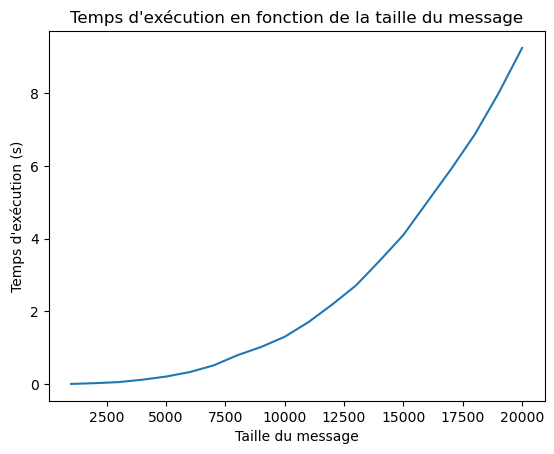

In [16]:
import matplotlib.pyplot as plt
from time import time


def bornes_kifli(n, pas):
    temps = []
    taille=[i for i in range(1, n+1) if i%pas==0]
    for i in taille:
        if(i%pas==0):
            message="".join(str(rd.randint(0,1)) for _ in range(i))
            t1=time()
            test_chiffrement_dechiffrement(message, i)
            t2=time()
            temps.append(t2-t1)
    plt.plot(taille, temps)
    plt.xlabel("Taille du message")
    plt.ylabel("Temps d'exécution (s)")
    plt.title("Temps d'exécution en fonction de la taille du message")
    plt.show()
bornes_kifli(20000, 1000)
    


Nous pouvons observer que la courbe générée converge vers une courbe exponentielle. Ainsi, l'algorithme complet de génération des clés, chiffrement d'un message et son déchiffrement.

Pour $n = 20000$, nous avons un temps d'exécution de 9 secondes.

## D'après vous, le NIST a-t-il eu raison de ne pas retenir le crypto-système de Kifli dans sa liste d'algorithmes post-quantique ?


N'ayant pas pu trouver d'informations complémentaire sur le crypto-système de Kifli donc à partir des informations donnés dans le sujet, il nous semble que ce crypto-système mérite une place dans la liste des algorithmes post-quantiques pour deux raisons.

En premier lieu, ce crypto-système semble respecter toutes les qualités que doivent respecter un crypto-système c'est à dire : 
- Confusion : Le message est inintelligible lorsqu'il est chiffré.
- Diffusion : Une modification légère du message change le message suffisament pour ne pas déduire des informations.
- Robustesse de la clé : La robustesse de la clé dépend grandement de la capacité à générer aléatoirement une paire clé publique clé privée efficacement, de plus la longueur de la clé doit être assez grande pour qu'elle soit robuste. Cependant si elle est bien généré alors la clé est robuste.

En second lieu, il rompt avec le problème de factorisation que propose l'algorithme clé publique, clé privée utilisé en ce moment (RSA) qui est un problème qui sera résolu avec l'apparition des ordinateurs quantiques.
En proposant à la place un problème NP-complet qui n'ai pas d'algorithmes permettant de résoudre tous les cas en compléxité polynomial n.
De plus cet algorithme a peu de chance d'exister dans le futur car il n'est pas certain qu'il puisse exister un tel algorithme.


Cependant, il nous semble pertinent de mentionner qu'en tant que 2ème année de BUT Informatique nous connaissons pas assez la cryptographie et la cryptanalyse nous permettant d'avoir le recul nécessaire pour affirmer que cet algorithme soit viable ou non pour le futur.



### Perspectives

#### Optimisation de la génération des clés :
On pourrait améliorer notre implémentation notamment en optimisant la génération de la paire clé privée, clé publique, car la génération d'un nombre W premier avec M est plutôt longue lorsque que le nombre M est grand. La génération de ce nombre permettrait d'augmenter la robustesse de la clé.

#### Convertir le message chiffré en binaire
Une autre perspective serait d'utiliser cette méthode de chiffremment pour que le résultat de chiffer soit un nombre binaire permettant le transfert d'un réel message sur un réseau. Une liste d'entiers n'est pas concrétement utilisable pour cet utilisation

#### Prise en charge de l'encodage/décodage du message 
On pourrait également prendre en charge l'encodage d'un texte en binaire avant le chiffrement et le décodage après le déchiffrement. Ce qui permettrait de pouvoir demander à chiffrer directement un message dans un language intelligible.


